In [1]:
import os, copy, math, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print('using', device)

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

using cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 26.0MB/s]


In [4]:
use_subset = True
subset_size = 5000
batch_size = 256 if use_subset else 128

if use_subset:
    subset_indices = list(range(subset_size))
    train_data = torch.utils.data.Subset(train_dataset, subset_indices)
else:
    train_data = train_dataset

In [5]:
loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=8, pin_memory=torch.cuda.is_available())

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# Cosine variance schedule
def cosine_schedule(T=1000, s=0.008, max_beta=0.999):
    t = np.arange(T+1, dtype=np.float64)
    f = np.cos(((t/T + s) / (1+s)) * np.pi/2)**2
    alphas = np.clip(f[1:] / f[:-1], 1 - max_beta, 1.0)
    alphas = np.concatenate([[1.0], alphas]).astype(np.float32)
    betas = (1.0 - alphas).astype(np.float32)
    abar = np.cumprod(alphas).astype(np.float32)
    return alphas, abar, betas

T = 1000
alpha, alpha_cumprod, beta = cosine_schedule(T)
alpha = torch.tensor(alpha, dtype=torch.float32, device=device)
alpha_cumprod = torch.tensor(alpha_cumprod, dtype=torch.float32, device=device)
beta = torch.tensor(beta, dtype=torch.float32, device=device)

In [7]:
# Forward noising
def prepare_batch(x0, alpha_cumprod):
    B = x0.size(0)
    t = torch.randint(1, T+1, (B,), device=x0.device)
    abar = alpha_cumprod[t].view(B,1,1,1)
    noise = torch.randn_like(x0)
    x_t = torch.sqrt(abar) * x0 + torch.sqrt(1 - abar) * noise
    return x_t, t, noise

In [8]:
# Sinusoidal time embedding
class TimeEmbedding(nn.Module):
    def __init__(self, T, embed_size):
        super().__init__()
        assert embed_size % 2 == 0
        t = torch.arange(0, T+1).unsqueeze(1)              # [T+1, 1]
        i = torch.arange(0, embed_size, 2).unsqueeze(0)    # [1, D/2]
        div_term = (10000 ** (i.float() / embed_size))     # [1, D/2]
        t = t.float()
        t_emb = torch.zeros((T+1, embed_size))
        t_emb[:, 0::2] = torch.sin(t / div_term)
        t_emb[:, 1::2] = torch.cos(t / div_term)
        self.register_buffer("time_encodings", t_emb)

    def forward(self, t):
        return self.time_encodings[t]

In [9]:
@torch.no_grad()
def generate_samples_ddim(model, alphas, alpha_cumprod, betas, time_embedding, labels, num_samples=16, steps=50, device='cuda', clamp_x0=True):
    model.eval()
    x = torch.randn(num_samples, 1, 28, 28, device=device)
    T_local = len(betas) - 1
    ts = torch.linspace(T_local, 1, steps, dtype=torch.long, device=device)
    for i in range(steps):
        t = int(ts[i].item())
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)
        eps_pred = model(x, time_embedding(t_batch), labels)
        abar_t = alpha_cumprod[t]
        x0_pred = (x - torch.sqrt(1 - abar_t) * eps_pred) / torch.sqrt(abar_t)
        if clamp_x0:
            x0_pred = torch.clamp(x0_pred, -1, 1)
        t_prev = int(ts[i+1].item()) if i+1 < steps else 0
        abar_prev = alpha_cumprod[t_prev]
        x = torch.sqrt(abar_prev) * x0_pred + torch.sqrt(1 - abar_prev) * eps_pred
    x = torch.clamp((x + 1) / 2, 0, 1)
    return x

In [10]:
# Residual Conv Block with GroupNorm
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, groups=4):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.gn1 = nn.GroupNorm(groups, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.gn2 = nn.GroupNorm(groups, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        h = F.relu(self.gn1(self.conv1(x)))
        h = self.gn2(self.conv2(h))
        return F.relu(h + self.skip(x))

In [11]:
class DeeperUNet(nn.Module):
    def __init__(self, time_embed_dim=64, base_ch=64, num_classes=10):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        # Time + label MLPs
        self.time_mlp1 = nn.Sequential(nn.Linear(time_embed_dim, base_ch), nn.ReLU())
        self.time_mlp2 = nn.Sequential(nn.Linear(time_embed_dim, base_ch*2), nn.ReLU())
        self.time_mlp3 = nn.Sequential(nn.Linear(time_embed_dim, base_ch*4), nn.ReLU())

        # Encoder
        self.enc1 = ResBlock(1, base_ch)       # 28x28 -> 28x28
        self.down1 = nn.Conv2d(base_ch, base_ch*2, 3, stride=2, padding=1)  # 28 -> 14

        self.enc2 = ResBlock(base_ch*2, base_ch*2)   # 14x14
        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, 3, stride=2, padding=1)  # 14 -> 7

        # Bottleneck
        self.bottleneck = ResBlock(base_ch*4, base_ch*4)

        # Decoder
        self.up1 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"),
                                 nn.Conv2d(base_ch*4, base_ch*2, 3, padding=1))  # 7 -> 14
        self.dec1 = ResBlock(base_ch*4, base_ch*2)

        self.up2 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"),
                                 nn.Conv2d(base_ch*2, base_ch, 3, padding=1))    # 14 -> 28
        self.dec2 = ResBlock(base_ch*2, base_ch)

        # Output
        self.out_conv = nn.Conv2d(base_ch, 1, 1)

    def forward(self, x, t_emb, labels):
        cond_emb = t_emb + self.label_emb(labels)

        # Project time embeddings for different stages
        t1 = self.time_mlp1(cond_emb).unsqueeze(-1).unsqueeze(-1)
        t2 = self.time_mlp2(cond_emb).unsqueeze(-1).unsqueeze(-1)
        t3 = self.time_mlp3(cond_emb).unsqueeze(-1).unsqueeze(-1)

        # Encoder
        e1 = self.enc1(x) + t1
        d1 = self.down1(e1)

        e2 = self.enc2(d1) + t2
        d2 = self.down2(e2)

        # Bottleneck
        b = self.bottleneck(d2) + t3

        # Decoder
        u1 = self.up1(b)
        u1 = torch.cat([u1, e2], dim=1)
        u1 = self.dec1(u1) + t2

        u2 = self.up2(u1)
        u2 = torch.cat([u2, e1], dim=1)
        u2 = self.dec2(u2) + t1

        return self.out_conv(u2)

In [12]:
# Simple U-Net
class SimpleUNet(nn.Module):
    def __init__(self, time_embed_dim=64, base_channels=128, num_classes=10):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        self.time_mlp_enc = nn.Sequential(nn.Linear(time_embed_dim, base_channels), nn.ReLU())
        self.time_mlp_bottleneck = nn.Sequential(nn.Linear(time_embed_dim, base_channels*2), nn.ReLU())
        self.time_mlp_dec = nn.Sequential(nn.Linear(time_embed_dim, base_channels), nn.ReLU())

        # Encoder block
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, base_channels, 3, padding=1),
            nn.GroupNorm(4, base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.GroupNorm(4, base_channels),
            nn.ReLU(inplace=True),
        )
        # Anti-alias downsample
        self.down = nn.Conv2d(base_channels, base_channels, kernel_size=3, stride=2, padding=1)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, 3, padding=1),
            nn.GroupNorm(4, base_channels*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.GroupNorm(4, base_channels*2),
            nn.ReLU(inplace=True),
        )

        # Anti-checkerboard upsample
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(base_channels*2, base_channels, kernel_size=3, padding=1)
        )

        # Decoder block
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, 3, padding=1),
            nn.GroupNorm(4, base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.GroupNorm(4, base_channels),
            nn.ReLU(inplace=True),
        )

        self.out_conv = nn.Conv2d(base_channels, 1, 1)

    def forward(self, x, t_emb, labels):
        label_emb = self.label_emb(labels)
        cond_emb = t_emb + label_emb
        t_proj_enc = self.time_mlp_enc(cond_emb).unsqueeze(-1).unsqueeze(-1)
        t_proj_bottleneck = self.time_mlp_bottleneck(cond_emb).unsqueeze(-1).unsqueeze(-1)
        t_proj_dec = self.time_mlp_dec(cond_emb).unsqueeze(-1).unsqueeze(-1)
        enc1 = self.enc1(x)
        enc1 = enc1 + t_proj_enc

        x = self.down(enc1)

        x = self.bottleneck(x)
        x = x + t_proj_bottleneck

        x = self.upconv(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)
        x = x + t_proj_dec

        out = self.out_conv(x)
        return out

In [13]:
N = len(train_data)
steps_per_epoch = math.ceil(N / batch_size)
target_steps = 50_000 if not use_subset else 20_000   # tweak as you like
epochs = math.ceil(target_steps / steps_per_epoch)
log_every_steps = 200
sample_every_steps = 500

print(f"N={N}, batch_size={batch_size}, steps_per_epoch={steps_per_epoch}, target_steps={target_steps}, epochs≈{epochs}")

N=5000, batch_size=256, steps_per_epoch=20, target_steps=20000, epochs≈1000


In [14]:
model = DeeperUNet().to(device)
ema_model = copy.deepcopy(model).to(device)
for p in ema_model.parameters():
    p.requires_grad_(False)

time_embedding = TimeEmbedding(T, embed_size=64).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=target_steps, eta_min=1e-5)
ema_decay = 0.999
grad_clip =1.0

In [15]:
global_step = 0
epoch = 0
while global_step < target_steps:
    for batch_images, labels in loader:
        batch_images, labels = batch_images.to(device), labels.to(device)
        x_t, t, noise = prepare_batch(batch_images, alpha_cumprod)
        t_emb = time_embedding(t)
        pred_noise = model(x_t, t_emb, labels)
        loss = loss_fn(pred_noise, noise)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            for ema_param, model_param in zip(ema_model.parameters(), model.parameters()):
                ema_param.data.mul_(ema_decay).add_(model_param.data, alpha=1-ema_decay)

        global_step += 1

        if global_step % log_every_steps == 0:
            print(f"step {global_step}/{target_steps} (epoch {epoch+1}), loss={loss.item():.4f}")

        if global_step % sample_every_steps == 0:
            with torch.no_grad():
                labels = torch.tensor([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5], device=device)
                samples = generate_samples_ddim(ema_model, alpha, alpha_cumprod, beta, time_embedding, labels=labels, num_samples=16, steps=50, device=device)
                save_image(samples, f'samples_step{global_step}.png', nrow=4)

        if global_step >= target_steps:
            break
    epoch += 1

step 200/20000 (epoch 10), loss=0.0948
step 400/20000 (epoch 20), loss=0.0971
step 600/20000 (epoch 30), loss=0.0741
step 800/20000 (epoch 40), loss=0.0786
step 1000/20000 (epoch 50), loss=0.0853
step 1200/20000 (epoch 60), loss=0.0826
step 1400/20000 (epoch 70), loss=0.0711
step 1600/20000 (epoch 80), loss=0.0702
step 1800/20000 (epoch 90), loss=0.0636
step 2000/20000 (epoch 100), loss=0.0787
step 2200/20000 (epoch 110), loss=0.0698
step 2400/20000 (epoch 120), loss=0.0643
step 2600/20000 (epoch 130), loss=0.0718
step 2800/20000 (epoch 140), loss=0.0663
step 3000/20000 (epoch 150), loss=0.0828
step 3200/20000 (epoch 160), loss=0.0651
step 3400/20000 (epoch 170), loss=0.0685
step 3600/20000 (epoch 180), loss=0.0659
step 3800/20000 (epoch 190), loss=0.0690
step 4000/20000 (epoch 200), loss=0.0876
step 4200/20000 (epoch 210), loss=0.0684
step 4400/20000 (epoch 220), loss=0.0643
step 4600/20000 (epoch 230), loss=0.0592
step 4800/20000 (epoch 240), loss=0.0552
step 5000/20000 (epoch 250), 

In [16]:
# Final sampling
with torch.no_grad():
    labels = torch.tensor([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5], device=device)
    samples = generate_samples_ddim(ema_model, alpha, alpha_cumprod, beta, time_embedding,
                                    labels=labels, num_samples=16, steps=50, device=device)
save_image(samples, 'samples_final.png', nrow=4)

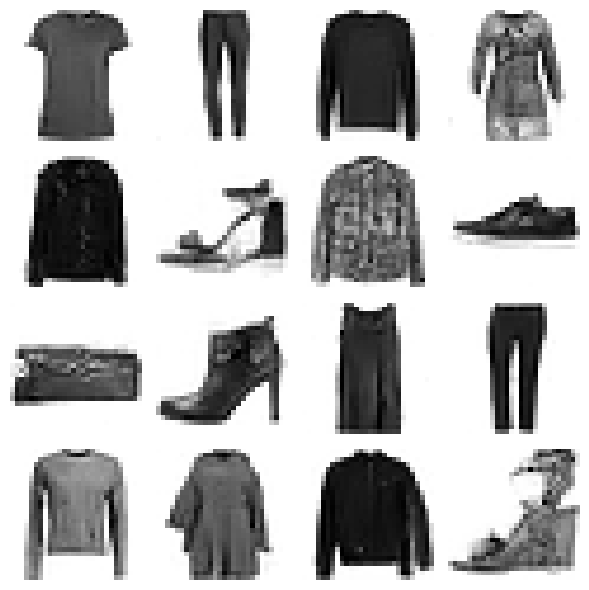

In [17]:
import matplotlib.pyplot as plt
samples_cpu = samples.squeeze(1).cpu()
fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    img = samples_cpu[i].numpy()
    ax.imshow(img, cmap='gray_r', interpolation='nearest')
    ax.axis('off')
plt.tight_layout()
plt.show()